# Strain mapping with all calibrations

___

## 1B: Prepare Data - Get vacuum probe

Obtain a vacuum probe template from the vacuum scan, and prepare it for template matching against the data.  If no vacuum scan is available but the experimental data contains a region of vacuum, this can be used instead.  If neither a vacuum scan nor vacuum region are available, generating a synthetic probe is often possible, though this approach is more difficult and may reduce accuracy.  For more on alternate approaches to vacuum probe generation, see py4DSTEM/notebooks/module_demos/braggdiskdetection/probetemplate.ipynb.

___

- Inputs:
  - vacuum scan
- Outputs:
  - vacuum probe template

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_average_probe_from_vacuum_scan
from py4DSTEM.process.braggdiskdetection import get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, append

In [2]:
# Examine contents of sampledata.h5

fp = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/sampledata.h5"
browser = py4DSTEM.file.io.FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    calibration_4DSTEM_scan             DataCube            
   1    experimental_4DSTEM_scan            DataCube            
   2    vacuum_4DSTEM_scan                  DataCube            
   3    CBED_shadow_image                   RealSlice           
   4    HAADF_image                         RealSlice           


In [3]:
# Load the vacuum scan

dc = browser.get_dataobject('vacuum_4DSTEM_scan')
browser.close()

### Get the average vacuum probe

Diffraction shifts - overall translation of the diffraction patterns due to scanning of the beam - mean that the vacuum probe is generally in a slightly different position on the detector at each scan position.  Here the vacuum probe from all the diffraction patterns are aligned *via* cross correlation, and averaged. 

In [4]:
# Get average, shift-corrected probe from ROI

mask_threshold = 0.2
mask_expansion = 12
mask_opening = 3
verbose = False

probe = get_average_probe_from_vacuum_scan(dc,
                                           mask_threshold=mask_threshold,
                                           mask_expansion=mask_expansion,
                                           mask_opening=mask_opening,
                                           verbose=verbose)

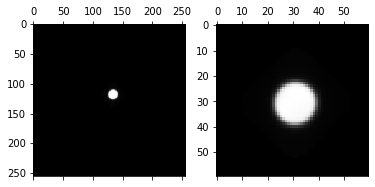

In [5]:
# Show average probe

rad = 30
xCoM_init,yCoM_init = get_CoM(probe)

fig,(ax1,ax2)=plt.subplots(1,2)
ax1.matshow(probe,cmap='gray')
ax2.matshow(probe[int(xCoM_init)-rad:int(xCoM_init)+rad,int(yCoM_init)-rad:int(yCoM_init)+rad])
plt.show()

### Create vacuum probe kernel

Before using the vacuum probe for template matching against the experimental diffraction patterns, we perform some additional processing to make it a more effective template.  Here, that vacuum probe kernel is generated by shifting the average probe to the corner of the image (i.e. centering / removing phase ramps in Fourier space).  We also subtract a wide gaussian such that the entire probe kernel integrates to zero.

In [6]:
sigma_probe_scale=4

probe_kernel = get_probe_kernel_subtrgaussian(probe, sigma_probe_scale=sigma_probe_scale)

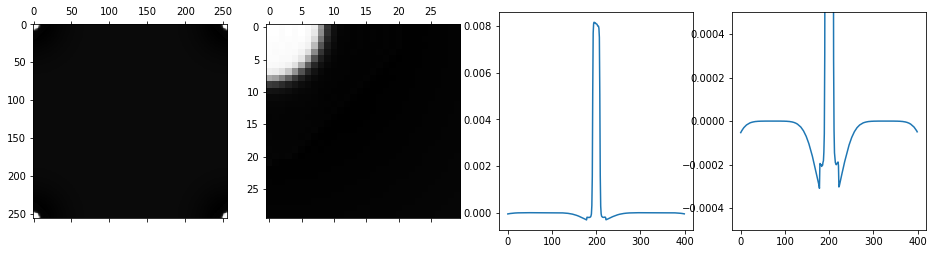

In [7]:
# Display probe_kernel, with line profile

rad=30
lineprofile_length=200
lineprofile_width=2

xCom,yCoM = np.unravel_index(np.argmax(probe_kernel),(dc.Q_Nx,dc.Q_Ny))
line_profile_left = np.sum(probe_kernel[-lineprofile_length:,:lineprofile_width],axis=(1))
line_profile_right = np.sum(probe_kernel[:lineprofile_length,:lineprofile_width],axis=(1))
line_profile = np.concatenate([line_profile_left,line_profile_right])

fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(16,4))
ax1.matshow(probe_kernel)
ax2.matshow(probe_kernel[:rad,:rad])
ax3.plot(np.arange(len(line_profile)),line_profile)
ax4.plot(np.arange(len(line_profile)),line_profile)
ax4.set_ylim(-0.0005,0.0005)
plt.show()

### Save the vacuum probe kernel

In [8]:
# Save both the average probe and the probe kernel

data = np.zeros((dc.Q_Nx,dc.Q_Ny,2))
data[:,:,0] = probe
data[:,:,1] = probe_kernel

probekernel_diffslice = DiffractionSlice(data=data, name='probe',slicelabels=['probe','probe_kernel'])

In [10]:
# Save

fp_processing = "/media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5"
append([probekernel_diffslice],fp_processing)

Opening file /media/AuxDriveB/Data/20190904_StrainMappingExample_with_Calibrations/LFP100_P1/processing_sampledata.h5...
Done.
